# Get_Template: 
This script constructs a very simple `template` of a miyake event. The sinusoidal component of the production function is ignored resulting in a smooth curve. The template is constructed using the best fitting `model`-`dataset` pair  from the 774AD year. `emcee` is used to fit the parameters of the production function which is then used to generate the `.csv` file containing the `dc14` concentrations over just the event.

In [114]:
from os import getcwd
from ticktack.fitting import SingleFitter
from ticktack import load_presaved_model
from jax.numpy import array, pi, mean, arange, full, sin
from plotnine import ggplot, geom_line, aes, theme_bw

In [115]:
carbon_box_model = load_presaved_model(     # Generating the CarbobBoxModel using ticktack
    "Guttler14",                            # Selecting an arbitrary model 
    production_rate_units="atoms/cm^2/s"    # Units of the model
)

bayesian_model = SingleFitter(carbon_box_model)   # Fitting a model 
bayesian_model.prepare_function(model="simple_sinusoid") # Generating the simple sin model
bayesian_model.load_data(f"{getcwd()}/datasets/775AD/NH/Miyake12_Cedar.csv")   

mcmc_samples = bayesian_model.MarkovChainSampler(
    array([775., 1./12, pi/2., 81./12]),    # Initial guess of the parameters
    likelihood=bayesian_model.log_joint_simple_sinusoid,    
    args=(array([770., 0., -pi, 0.]), array([780., 5., pi, 15.])) # Upper and lower bounds
)   

Running burn-in...


100%|██████████| 500/500 [00:42<00:00, 11.72it/s]


Running production...


100%|██████████| 1000/1000 [01:20<00:00, 12.46it/s]


In [125]:
bayesian_model.annual = arange(750, 800)
bayesian_model.mask = full((50,), True, dtype=bool)

In [124]:
parameters = mean(mcmc_samples, axis=0)

In [127]:
template = bayesian_model.dc14(params=parameters)
template -= bayesian_model.steady_state_production * 0.18 * sin()

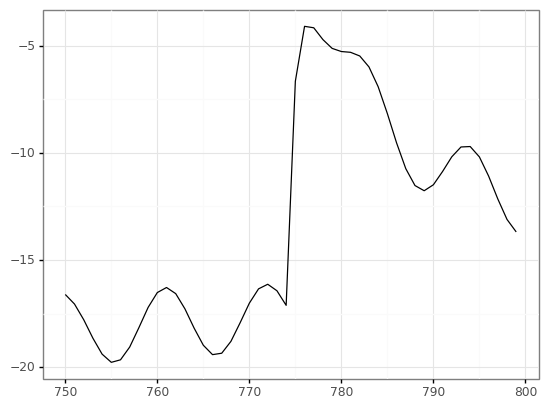

<ggplot: (8754871797688)>

In [128]:
(ggplot(aes(x=bayesian_model.annual, y=template))
    + geom_line()
    + theme_bw())